In [2]:
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import Subset



# Crop all Images to the Same Size

In [3]:
"""
def resize_image(input_path, output_path, desired_width=720, desired_height=720):
    #Resize an image to the desired size by cropping or padding, handling alpha channel if present.
    # Open the image
    img = Image.open(input_path)
    
    # Convert images with alpha channel to 'RGBA' to maintain transparency
    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
        background = Image.new('RGBA', (desired_width, desired_height), (255, 255, 255, 0))
    else:
        img = img.convert('RGB')
        background = Image.new('RGB', (desired_width, desired_height), (255, 255, 255))
    
    delta_width = desired_width - img.width
    delta_height = desired_height - img.height
    
    if delta_width >= 0 and delta_height >= 0:
        # Image needs padding
        padding = (delta_width // 2, delta_height // 2)
        background.paste(img, (padding[0], padding[1]))
    else:
        # Image needs cropping
        left = max(-delta_width // 2, 0)
        upper = max(-delta_height // 2, 0)
        right = img.width + min(delta_width // 2, 0)
        lower = img.height + min(delta_height // 2, 0)
        img = img.crop((left, upper, right, lower))
        background.paste(img, (0, 0))

    # Convert to 'RGB' if necessary (for JPEG compatibility)
    if background.mode == 'RGBA':
        final_img = background.convert('RGB')
    else:
        final_img = background

    # Save the resized image
    final_img.save(output_path)

def process_images(source_folder, target_folder, desired_width=720, desired_height=720):
    #Process all images in the source folder and save them to the target folder with customizable dimensions.
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            input_path = os.path.join(source_folder, filename)
            output_path = os.path.join(target_folder, filename)
            resize_image(input_path, output_path, desired_width, desired_height)

# Example usage with custom dimensions
desired_width = 720
desired_height = 720
process_images('dataset/AiArtData', 'dataset/AiArtData_resized', desired_width, desired_height)
process_images('dataset/RealArt', 'dataset/RealArt_resized', desired_width, desired_height)
"""


"\ndef resize_image(input_path, output_path, desired_width=720, desired_height=720):\n    #Resize an image to the desired size by cropping or padding, handling alpha channel if present.\n    # Open the image\n    img = Image.open(input_path)\n    \n    # Convert images with alpha channel to 'RGBA' to maintain transparency\n    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):\n        background = Image.new('RGBA', (desired_width, desired_height), (255, 255, 255, 0))\n    else:\n        img = img.convert('RGB')\n        background = Image.new('RGB', (desired_width, desired_height), (255, 255, 255))\n    \n    delta_width = desired_width - img.width\n    delta_height = desired_height - img.height\n    \n    if delta_width >= 0 and delta_height >= 0:\n        # Image needs padding\n        padding = (delta_width // 2, delta_height // 2)\n        background.paste(img, (padding[0], padding[1]))\n    else:\n        # Image needs cropping\n        left = max(

# Organize the Images into Train and Test Folders

In [4]:
dataset_dir = 'dataset'
categories = ['AiArtData_resized', 'RealArt_resized']

# Split ratios
train_size = 0.9  # 90% for training, 10% for testing

for category in categories:
    src_dir = os.path.join(dataset_dir, category)
    
    filenames = os.listdir(src_dir)
    filenames = [f for f in filenames if os.path.isfile(os.path.join(src_dir, f))]
    
    # Split data into training and test sets
    train_filenames, test_filenames = train_test_split(filenames, train_size=train_size, random_state=42)
    
    def copy_files(files, src_dir, dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
        for f in files:
            shutil.copy(os.path.join(src_dir, f), os.path.join(dest_dir, f))
    
    copy_files(train_filenames, src_dir, os.path.join(dataset_dir, 'train', category))
    copy_files(test_filenames, src_dir, os.path.join(dataset_dir, 'test', category))

print("Data split into training and test sets.")


Data split into training and test sets.


# Create Train and Validation Sets

In [5]:
# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor format
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

dataset_dir = 'dataset/train'  
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)


In [6]:
print(dataset.classes)

['AiArtData_resized', 'RealArt_resized']


In [7]:
def split_indices(n, val_frac, seed):
    n_val = int(val_frac * n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

# Parameters for splitting the dataset
val_frac = 0.3
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)


In [8]:
batch_size = 16

# Training DataLoader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

# Validation DataLoader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)


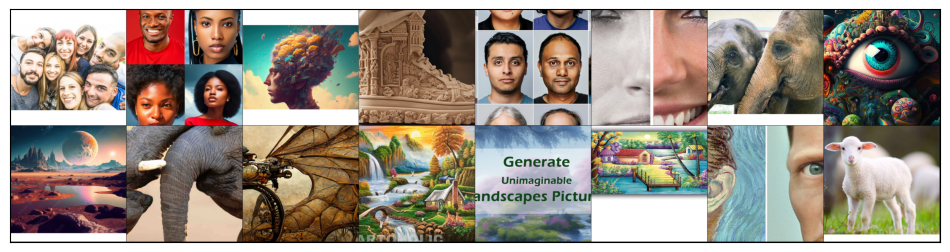

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)


# Build Model Architecture

# Enable GPU Training

In [10]:
import torch
import torchvision
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [11]:

print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)
print("Number of CUDA devices:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")


Is CUDA available: True
CUDA version: 12.1
PyTorch version: 2.2.0+cu121
Number of CUDA devices: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Ti


In [12]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3, dropout_rate=0.2):
        super(ImageClassifierNet, self).__init__()
        # convolutional layers with dropout
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Dropout layer after pooling
        )
        
        with torch.no_grad():
            self.dummy_input = torch.autograd.Variable(torch.rand(1, n_channels, 720, 720)) ##adjust these numbers for image dimension
            dummy_output = self.conv_layers(self.dummy_input)
            self.flattened_size = int(torch.numel(dummy_output) / dummy_output.shape[0])
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout layer after first ReLU
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout layer after second ReLU
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.flattened_size)  
        x = self.fc_layers(x)
        return x

In [13]:
model = ImageClassifierNet()

In [14]:
summary(model, input_size=(batch_size, 3, 720, 720)) ##adjust these numbers for image dimension

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [16, 2]                   --
├─Sequential: 1-1                        [16, 8, 360, 360]         --
│    └─Conv2d: 2-1                       [16, 8, 720, 720]         224
│    └─ReLU: 2-2                         [16, 8, 720, 720]         --
│    └─MaxPool2d: 2-3                    [16, 8, 360, 360]         --
│    └─Dropout: 2-4                      [16, 8, 360, 360]         --
├─Sequential: 1-2                        [16, 2]                   --
│    └─Linear: 2-5                       [16, 128]                 132,710,528
│    └─ReLU: 2-6                         [16, 128]                 --
│    └─Dropout: 2-7                      [16, 128]                 --
│    └─Linear: 2-8                       [16, 64]                  8,256
│    └─ReLU: 2-9                         [16, 64]                  --
│    └─Dropout: 2-10                     [16, 64]                  --
│ 

In [15]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("GPU Training Enabled")
        return torch.device('cuda')
    else:
        print("CPU Training Enabled")
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [16]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

GPU Training Enabled


ImageClassifierNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1036800, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Train Model

In [17]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    loss_list = []
    iteration_list = []
    accuracy_list = []
    
    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
    count = 0
    # Change learning rate
    for g in opt_fn.param_groups:
        g['lr'] = lr
      
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_accuracy = 0.0, 0.0  # Track the training loss and accuracy for this epoch
        correct = 0.0 
        total = 0.0
        for inputs, labels in train_dl:
            images, labels = inputs.to(device), labels.to(device) #move to GPU or CPU
            
            outputs = model(images)  # forward pass
            loss = loss_fn(outputs, labels)  #get loss
            opt_fn.zero_grad() 
            loss.backward()  #backward pass
            opt_fn.step()  # update  param
            train_loss += loss.item() * batch_size  #track loss
            _, preds = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            #train_accuracy += torch.sum(preds == labels.data)  # Track the total number of correct predictions

        # compute the average loss and accuracy for this epoch
        train_loss = train_loss
        train_accuracy = 100 * correct / total

        #validation
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        val_total , val_correct = 0.0 , 0.0
        if val_dl:
            with torch.no_grad():
                for inputs, labels in val_dl:
                    images, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item() * batch_size
                    _, preds = torch.max(outputs, 1)

                    val_total += labels.size(0)
                    val_correct += (preds == labels).sum().item()
            val_loss = val_loss
            if val_total != 0:
                val_accuracy = 100 * val_correct / val_total
            else:
                val_accuracy = None
        else:
            val_accuracy = None

        # record the loss and accuracy for this epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print progress
        if val_accuracy is not None:
            print("Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
        else:
            print("Epoch {}/{}, train_loss: {:.4f}, train_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, train_accuracy))
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [18]:

import torch.optim as optim
from torch.optim import SGD
num_epochs = 150 # Number of training epochs
loss_fn = nn.CrossEntropyLoss() # Define the loss function
lr = 0.0001 # Set the learning rate
#opt_fn = optim.SGD(model.parameters(), lr=lr)  # Select an optimizer function
opt_fn = torch.optim.Adam(model.parameters(), lr=lr) # Select an optimizer function


In [19]:
torch.cuda.empty_cache()


In [20]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch 1/150, train_loss: 671.1704, val_loss: 186.2634, train_accuracy: 50.9464, val_accuracy: 66.0517
Epoch 2/150, train_loss: 475.6639, val_loss: 184.7994, train_accuracy: 55.0473, val_accuracy: 61.9926
Epoch 3/150, train_loss: 449.3933, val_loss: 181.7401, train_accuracy: 54.7319, val_accuracy: 56.4576
Epoch 4/150, train_loss: 447.6238, val_loss: 187.7314, train_accuracy: 52.6814, val_accuracy: 57.1956
Epoch 5/150, train_loss: 440.2508, val_loss: 186.2993, train_accuracy: 56.7823, val_accuracy: 56.4576
Epoch 6/150, train_loss: 440.5711, val_loss: 187.1501, train_accuracy: 56.3091, val_accuracy: 56.4576
Epoch 7/150, train_loss: 438.7953, val_loss: 183.6941, train_accuracy: 57.0978, val_accuracy: 56.4576
Epoch 8/150, train_loss: 434.5103, val_loss: 182.5393, train_accuracy: 56.9401, val_accuracy: 56.4576
Epoch 9/150, train_loss: 427.7657, val_loss: 180.3342, train_accuracy: 57.0978, val_accuracy: 56.4576
Epoch 10/150, train_loss: 427.0724, val_loss: 179.0517, train_accuracy: 57.0978, v

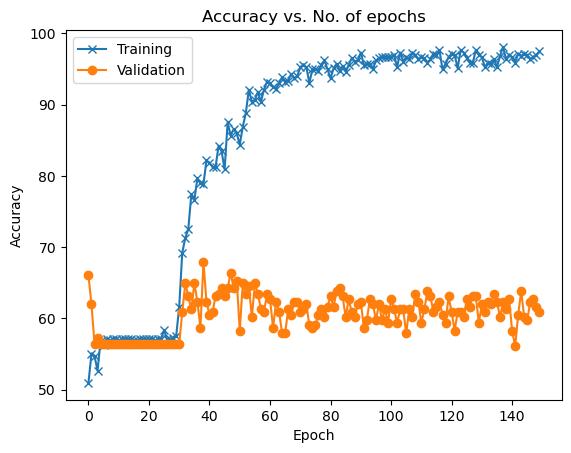

In [21]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")
plot_accuracy(train_accuracies, val_accuracies)

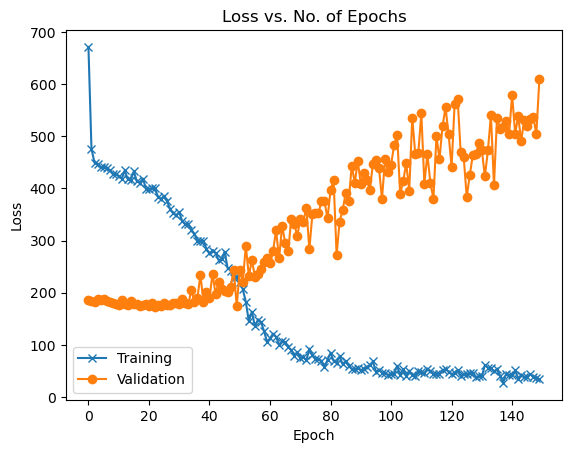

In [22]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")
plot_losses(train_losses, val_losses)

# Check Predictions

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),  # images to tensor 
])

dataset_dir = 'dataset/test'  
test = datasets.ImageFolder(root=dataset_dir, transform=transform)

test_dl = DataLoader(test, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

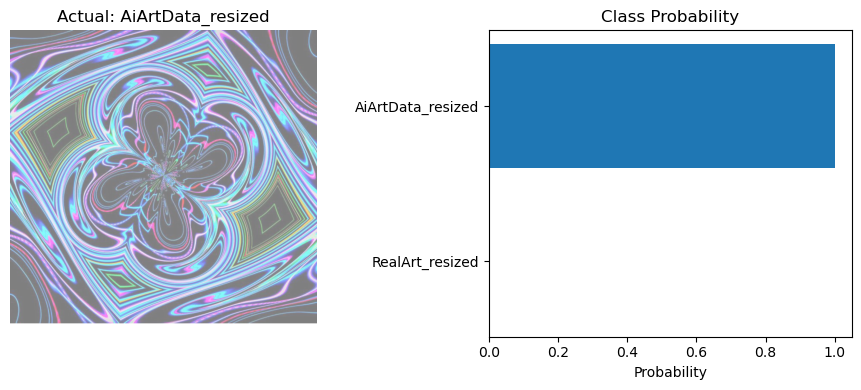

In [24]:
def view_classification(img, actual_label, probs, classes):
    """
    Visualize the image, the actual label, and the predicted probabilities.
    """
    # Unnormalization
    img = img.permute(1, 2, 0).numpy() * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    img = np.clip(img, 0, 1)
    
    # Showing image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    ax1.imshow(img)
    ax1.set_title(f'Actual: {classes[actual_label]}')
    ax1.axis('off')
    
    num_classes = len(classes)
    if len(probs) != num_classes:
        raise ValueError(f"The number of probabilities ({len(probs)}) does not match the number of classes ({num_classes}).")

    # Bar chart for the probabilities
    y_pos = np.arange(num_classes)
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()  
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probability')
    plt.tight_layout()
    plt.show()


model.eval()  

images, labels = next(iter(test_dl))
idx = np.random.choice(len(images))  
img, label = images[idx], labels[idx]

img = img.to(device).unsqueeze(0)  

with torch.no_grad():
    output = model(img)
    probs = torch.nn.functional.softmax(output, dim=1)[0] 
    probs = probs.cpu().numpy()  

view_classification(images[idx].cpu(), label.cpu().item(), probs, dataset.classes)



# Check Accuracy

In [25]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f'Accuracy of the network on the test images: {accuracy * 100:.2f}%')


Accuracy of the network on the test images: 78.26%


Other Performance Metrics

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Append predictions and true labels
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Calculate metrics
precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:\n", conf_matrix)

# For ROC AUC and PR AUC, you'll need the probability scores of the positive class, which might require adjusting the above code to use model output probabilities directly.


Precision: 0.81
Recall: 0.55
F1 Score: 0.66
Confusion Matrix:
 [[132  11]
 [ 39  48]]


Save Trained CNN

In [55]:
# Save the model
#model_dir = r'C:\Users\Arya Rahmanian\Documents\realvsAI\model\model.pth'

# Create the directory if it does not exist

torch.save(model, "realVSAI_model" )
